In [89]:
import os, math, csv, argparse, random
from typing import Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import resnet18
from tqdm.notebook import tqdm
import csv, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------
#  Utils: seed & split
# -------------------------
def set_seed(seed: int = 20251013):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def stratified_split(y, val_ratio=0.2, seed=20251013):
    """stratified split on noisy labels y (1D numpy array)"""
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    idx = np.arange(len(y))
    tr_idx, val_idx = [], []
    for c in np.unique(y):
        c_idx = idx[y == c]
        rng.shuffle(c_idx)
        n_val = int(round(len(c_idx) * val_ratio))
        val_idx.append(c_idx[:n_val])
        tr_idx.append(c_idx[n_val:])
    return np.concatenate(tr_idx), np.concatenate(val_idx)

# -------------------------
#  Data helpers
# -------------------------
def infer_image_shape(x2d: np.ndarray) -> Tuple[int,int,int]:
    D = x2d.shape[1]
    if D == 28*28: return (1, 28, 28)
    if D == 32*32*3: return (3, 32, 32)
    s = int(round(math.sqrt(D)))
    if s*s == D: return (1, s, s)
    return (1, 1, D)

def to_tensor_images(x: np.ndarray) -> torch.Tensor:
    x = x.astype(np.float32)
    if x.max() > 1.5: x = x/255.0  # [0,1]
    if x.ndim == 2:
        C,H,W = infer_image_shape(x); x = x.reshape((-1, C, H, W))
    elif x.ndim == 3:  # (N,H,W)
        x = x[:, None, ...]
    elif x.ndim == 4 and x.shape[-1] in (1,3):  # (N,H,W,C) -> (N,C,H,W)
        x = np.transpose(x, (0,3,1,2))
    return torch.from_numpy(x)

class NumpyTensorDataset(torch.utils.data.Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, aug: bool=False):
        self.X = to_tensor_images(X)  # (N,C,H,W) float32 in [0,1]
        self.y = torch.from_numpy(y.astype(np.int64))
        self.aug = aug

    def __len__(self): return self.X.size(0)

    def __getitem__(self, i):
        x, y = self.X[i], self.y[i]

        if self.aug and x.shape[0]==3 and x.shape[-2:]==(32,32):
            # random horizontal flip
            if random.random() < 0.5:
                x = torch.flip(x, dims=[2])
            # random crop 32 with padding=4（reflect padding）
            pad = 4
            x = F.pad(x, (pad,pad,pad,pad), mode='reflect')
            i0 = random.randint(0, 2*pad)
            j0 = random.randint(0, 2*pad)
            x = x[:, j0:j0+32, i0:i0+32]
        return x, y

# -------------------------
#  Models
# -------------------------
class SmallCNN(nn.Module):
    def __init__(self, in_ch=1, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1), nn.ReLU(True), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),    nn.ReLU(True), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),   nn.ReLU(True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.net(x).flatten(1)
        return self.fc(x)

def make_resnet18_cifar(in_ch: int, num_classes: int):
    m = resnet18(weights=None)
    m.conv1  = nn.Conv2d(in_ch, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(512, num_classes)
    return m

# -------------------------
#  (Optional) forward correction
# -------------------------
def row_normalize(T: torch.Tensor) -> torch.Tensor:
    return T / (T.sum(dim=1, keepdim=True) + 1e-12)

def forward_ce_loss(logits, y_noisy, T):
    probs = torch.softmax(logits, dim=1)
    noisy_probs = probs @ T
    log_noisy = torch.log(noisy_probs + 1e-12)
    return F.nll_loss(log_noisy, y_noisy)

@torch.no_grad()
def estimate_T_anchor(model, loader, num_classes, device, topk=0.02, min_prob=0.0):
    model.eval()
    probs_all, pred_all, noisy_all = [], [], []
    for x, s in loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu()
        probs_all.append(probs)
        pred_all.append(probs.argmax(1))
        noisy_all.append(s)
    probs = torch.cat(probs_all); preds = torch.cat(pred_all); noisy = torch.cat(noisy_all)
    T = torch.zeros((num_classes, num_classes), dtype=torch.float64)
    for i in range(num_classes):
        idx = (preds == i).nonzero(as_tuple=False).squeeze(1)
        if idx.numel() == 0:
            T[i] = torch.full((num_classes,), 1.0/num_classes, dtype=torch.float64); continue
        keep = idx[probs[idx, i] >= min_prob] if min_prob>0 else torch.empty(0, dtype=torch.long)
        use = keep if keep.numel()>0 else idx[probs[idx, i].argsort(descending=True)[:max(1, int(math.ceil(idx.numel()*topk)))]]
        #hist = torch.bincount(noisy[use], minlength=num_classes).double()
        #T[i] = hist / hist.sum().clamp_min(1.0)
        hist = torch.bincount(noisy[use], minlength=num_classes).double()
        eps = 1.0
        T[i] = (hist + eps) / (hist.sum() + eps * num_classes)
    return T.float()

# -------------------------
#  Metrics
# -------------------------
def macro_f1_from_preds(y_true: np.ndarray, y_pred: np.ndarray, K: int) -> float:
    cm = np.zeros((K, K), dtype=np.int64)
    for t, p in zip(y_true, y_pred): cm[t, p] += 1
    f1s = []
    for k in range(K):
        tp = cm[k,k]; fp = cm[:,k].sum()-tp; fn = cm[k,:].sum()-tp
        prec = tp / (tp+fp+1e-12); reca = tp / (tp+fn+1e-12)
        f1s.append(2*prec*reca/(prec+reca+1e-12))
    return float(np.mean(f1s))

def ece_score(probs: np.ndarray, y_true: np.ndarray, n_bins: int = 15) -> float:
    conf = probs.max(1); pred = probs.argmax(1)
    bins = np.linspace(0.,1.,n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        m = (conf > lo) & (conf <= hi)
        if not np.any(m): continue
        ece += (m.mean())*abs((pred[m]==y_true[m]).mean() - conf[m].mean())
    return float(ece)

@torch.no_grad()
def evaluate(model, loader, num_classes, device):
    model.eval()
    tot, correct, nll_sum = 0, 0, 0.0
    probs_all, y_all, p_all = [], [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        nll_sum += F.nll_loss(torch.log(probs+1e-12), y, reduction='sum').item()
        pred = probs.argmax(1)
        correct += (pred==y).sum().item()
        tot += y.size(0)
        probs_all.append(probs.cpu()); y_all.append(y.cpu()); p_all.append(pred.cpu())
    probs = torch.cat(probs_all).numpy()
    y_true = torch.cat(y_all).numpy()
    y_pred = torch.cat(p_all).numpy()
    return dict(
        acc=float(correct/tot),
        macro_f1=float(macro_f1_from_preds(y_true, y_pred, num_classes)),
        nll=float(nll_sum/tot),
        ece=float(ece_score(probs, y_true, n_bins=15))
    )

# -------------------------
#  Train loop
# -------------------------
def train_one(dataset_name, Xtr, Str, Xval, Sval, Xte, Yte, T_given, C,
              epochs=120, batch_size=256, lr=1e-3, weight_decay=1e-4,
              warmup_epochs=0, topk=0.02, min_prob=0.0, mixT=0.0,
              seed=20251013, device='cpu', arch='resnet18',
              do_overfit_check=True):

    set_seed(seed)
    num_classes = int(C)

    train_ds = NumpyTensorDataset(Xtr, Str, aug=True)
    val_ds   = NumpyTensorDataset(Xval, Sval, aug=False)
    test_ds  = NumpyTensorDataset(Xte,  Yte,  aug=False)

    Xtmp = to_tensor_images(Xtr).float()
    if Xtmp.max() > 1.5: Xtmp /= 255.0
    train_mean = Xtmp.mean(dim=(0,2,3))
    train_std  = Xtmp.std(dim=(0,2,3)).clamp_min(1e-6)
    with torch.no_grad():
        for ds in (train_ds, val_ds, test_ds):
            ds.X.sub_(train_mean[None,:,None,None]).div_(train_std[None,:,None,None])

    # DataLoader
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # Quick Print Self-Test
    xb, yb = next(iter(train_loader))
    print('num_classes C =', num_classes)
    print('label min/max:', int(Str.min()), int(Str.max()))
    print('label counts:', np.bincount(Str, minlength=num_classes)[:10], '...')
    print('shape:', xb.shape)
    print('range:', float(xb.min()), float(xb.max()))
    ch_mean = xb.mean(dim=(0,2,3)); ch_std = xb.std(dim=(0,2,3))
    print('per-channel mean:', [float(m) for m in ch_mean])
    print('per-channel std :', [float(s) for s in ch_std])

    # Model & Optimizer (ResNet18 on CIFAR-stem)
    in_ch = train_ds.X.shape[1]
    use_resnet = (arch == 'resnet18') or (arch == 'auto' and in_ch == 3)
    print("[DEBUG] use_resnet =", use_resnet, "| arch passed =", arch)

    if use_resnet:
        model = make_resnet18_cifar(in_ch, num_classes).to(device)
        opt = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    else:
        model = SmallCNN(in_ch=in_ch, num_classes=num_classes).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = None


    do_overfit_check=False
    if do_overfit_check:
        idx = torch.randperm(len(train_ds))[:256]
        x_small = train_ds.X[idx].clone()
        y_small = train_ds.y[idx].clone()
        small_loader = DataLoader(TensorDataset(x_small, y_small), batch_size=256, shuffle=True)

        state = {k: v.clone() for k, v in model.state_dict().items()}
        model.train()
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d): m.eval()

        of_opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        best = 0.0
        for t in range(1000):
            for xb_, yb_ in small_loader:
                xb_, yb_ = xb_.to(device), yb_.to(device)
                logits = model(xb_); loss = F.cross_entropy(logits, yb_)
                of_opt.zero_grad(); loss.backward(); of_opt.step()
            with torch.no_grad():
                pred = logits.argmax(1); acc = (pred==yb_).float().mean().item()
            if (t+1) % 100 == 0:
                print(f"[overfit] step {t+1}: loss={loss.item():.4f}, acc={acc:.4f}")
            best = max(best, acc)
            if best > 0.99: break
        print("[overfit] best acc:", best)
        model.load_state_dict(state)


    warmup_eff = int(warmup_epochs)

    T_used = None
    if (T_given is not None) and (warmup_eff == 0):
        T_used = row_normalize(T_given.clone().to(device))

    # Training cycle (scheduler step after optimization in each epoch)
    T_accum = None
    cnt = 0

    for ep in tqdm(range(epochs), desc=f"Training (Seed {seed})", unit="epoch", leave=False):
        model.train()
        for x, y_noisy in train_loader:
            x, y_noisy = x.to(device), y_noisy.to(device)
            logits = model(x)
            loss = F.cross_entropy(logits, y_noisy) if (T_used is None or ep < warmup_eff) \
                  else forward_ce_loss(logits, y_noisy, T_used)
            opt.zero_grad(); loss.backward(); opt.step()


        if T_given is None and warmup_eff > 0 and (ep+1) >= warmup_eff-2 and (ep+1) <= warmup_eff:
            T_hat = estimate_T_anchor(model, val_loader, num_classes, device,
                                      topk=topk, min_prob=min_prob)
            T_hat = row_normalize(T_hat.to(device))
            if mixT > 0.0:
                I = torch.eye(num_classes, device=device)
                T_hat = row_normalize((1.0 - mixT)*T_hat + mixT*I)
            T_accum = T_hat if T_accum is None else (T_accum + T_hat)
            cnt += 1


        if (ep+1) == warmup_eff and T_given is None and warmup_eff > 0:
            T_used = row_normalize(T_accum / cnt)
            Th = T_used.detach().cpu().numpy()
            print('[T_hat(avg)] diag =', np.round(np.diag(Th), 3))
            print('[T_hat(avg)] rowsum =', np.round(Th.sum(axis=1), 3))
            print('[T_hat(avg)]\n', np.round(Th, 3))

        if scheduler is not None:
            scheduler.step()

    metrics = evaluate(model, test_loader, num_classes, device)
    return metrics, (T_used.detach().cpu().numpy() if T_used is not None else None)

# -------------------------
#  NPZ loader
# -------------------------
def load_npz_dataset(path: str):
    d = np.load(path, allow_pickle=True)
    keys_all = list(d.keys())

    def pick(*cands):
        for k in cands:
            if k in d: return k
        raise KeyError(f"Missing any of {cands} in file. Found keys={keys_all}")

    k_Xtr = pick('Xtr','X_train','Xtrain','X_tr')
    k_Str = pick('Str','ytr','S','y_train','Ytr','Y_tr')
    k_Xte = pick('Xte','Xts','X_test','Xtest','X_te','X_ts')
    k_Yte = pick('Yte','Yts','yte','Y_test','Ytest','Y_te','Y_ts')
    k_T   = 'T' if 'T' in d else None

    Xtr, Str = d[k_Xtr], d[k_Str]
    Xte, Yte = d[k_Xte], d[k_Yte]
    T = d[k_T].astype(np.float32) if k_T else None
    C = int(max(Str.max(), Yte.max()) + 1)

    print(f"[keys] {keys_all}")
    print(f"[mapping] Xtr={k_Xtr}, Str={k_Str}, Xte={k_Xte}, Yte={k_Yte}, T={'T' if k_T else 'None'}")
    return Xtr, Str, Xte, Yte, T, C


In [90]:
# -------------------------
#  Configuration
# -------------------------
class Config:
    data = '/content/FashionMNIST0.3.withT.npz'
    arch = 'cnn'
    runs = 10
    epochs = 50
    warmup_epochs = 0
    topk = 0.02
    min_prob = 0.0
    mixT = 0.0
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 256
    lr = 1e-3
    weight_decay = 1e-4
    val_ratio = 0.2
    seed = 20251013

args = Config()

# -------------------------
#  Main Logic (from main())
# -------------------------

Xtr, Str, Xte, Yte, T, C = load_npz_dataset(args.data)
dataset_name = os.path.splitext(os.path.basename(args.data))[0]

device = torch.device(args.device)


os.makedirs('results', exist_ok=True)
out_csv = os.path.join('results', f'{dataset_name}_forward_runs.csv')
out_Tnpz = os.path.join('results', f'{dataset_name}_T_used_runs.npz')

# CSV header
with open(out_csv, 'w', newline='') as f:
    csv.writer(f).writerow(['run', 'acc', 'macro_f1', 'nll', 'ece'])

all_metrics = []
T_collection = {}

for r in range(args.runs):
    seed = args.seed + r
    print(f"\n--- Starting Run {r+1}/{args.runs} (Seed: {seed}) ---")

    # stratified split on noisy labels
    tr_idx, val_idx = stratified_split(Str, val_ratio=args.val_ratio, seed=seed)
    X_tr, S_tr = Xtr[tr_idx], Str[tr_idx]
    X_val, S_val = Xtr[val_idx], Str[val_idx]

    metrics, T_used = train_one(
        dataset_name, X_tr, S_tr, X_val, S_val, Xte, Yte,
        None if T is None else torch.from_numpy(T),
        C=C,
        epochs=args.epochs, batch_size=args.batch_size,
        lr=args.lr, weight_decay=args.weight_decay,
        warmup_epochs=args.warmup_epochs, topk=args.topk,
        min_prob=args.min_prob, mixT=args.mixT,
        seed=seed, device=device,
        arch=args.arch
    )

    all_metrics.append(metrics)
    with open(out_csv, 'a', newline='') as f:
        csv.writer(f).writerow([r+1, metrics['acc'], metrics['macro_f1'], metrics['nll'], metrics['ece']])
    print(f"Run {r+1}/{args.runs}: acc={metrics['acc']:.4f}, macroF1={metrics['macro_f1']:.4f}, "
          f"NLL={metrics['nll']:.4f}, ECE={metrics['ece']:.4f}")

    if T_used is not None:
        T_collection[f'T_run{r+1}'] = T_used


accs  = np.array([m['acc'] for m in all_metrics], dtype=np.float64)
f1s   = np.array([m['macro_f1'] for m in all_metrics], dtype=np.float64)
nlls  = np.array([m['nll'] for m in all_metrics], dtype=np.float64)
eces  = np.array([m['ece'] for m in all_metrics], dtype=np.float64)

mean_acc, std_acc = accs.mean(), accs.std()
mean_f1,  std_f1  = f1s.mean(),  f1s.std()
mean_nll, std_nll = nlls.mean(), nlls.std()
mean_ece, std_ece = eces.mean(), eces.std()

print("\n" + "="*30)
print(f"==> [{dataset_name}]  acc  = {mean_acc:.4f} ± {std_acc:.4f}")
print(f"==> [{dataset_name}]  F1   = {mean_f1:.4f}")
print(f"==> [{dataset_name}]  NLL  = {mean_nll:.4f}")
print(f"==> [{dataset_name}]  ECE  = {mean_ece:.4f}")
print(f"==>  Results saved to: {out_csv}")
print("="*30)


with open(out_csv, 'a', newline='') as f:
    w = csv.writer(f)
    w.writerow(['---', '---', '---', '---', '---'])
    w.writerow(['mean', mean_acc, mean_f1, mean_nll, mean_ece])
    w.writerow(['std',  std_acc,  std_f1,  std_nll,  std_ece])

if len(T_collection):
    np.savez(out_Tnpz, **T_collection)
    print(f"==> T matrices saved to: {out_Tnpz}")



[keys] ['Xtr', 'Str', 'Xte', 'Yte', 'T']
[mapping] Xtr=Xtr, Str=Str, Xte=Xte, Yte=Yte, T=T

--- Starting Run 1/10 (Seed: 20251013) ---
num_classes C = 3
label min/max: 0 2
label counts: [4874 4744 4782] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8260604739189148 2.078202486038208
per-channel mean: [-0.06749261915683746]
per-channel std : [0.9687440395355225]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251013):   0%|          | 0/50 [00:00<?, ?epoch/s]

Run 1/10: acc=0.9920, macroF1=0.9920, NLL=0.0236, ECE=0.0040

--- Starting Run 2/10 (Seed: 20251014) ---
num_classes C = 3
label min/max: 0 2
label counts: [4874 4744 4782] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8248255252838135 2.0798137187957764
per-channel mean: [-0.015195043757557869]
per-channel std : [1.0017752647399902]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251014):   0%|          | 0/50 [00:00<?, ?epoch/s]

Run 2/10: acc=0.9887, macroF1=0.9887, NLL=0.0371, ECE=0.0061

--- Starting Run 3/10 (Seed: 20251015) ---
num_classes C = 3
label min/max: 0 2
label counts: [4874 4744 4782] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8251965045928955 2.0785837173461914
per-channel mean: [-0.0052062710747122765]
per-channel std : [0.9865990877151489]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251015):   0%|          | 0/50 [00:00<?, ?epoch/s]

Run 3/10: acc=0.9927, macroF1=0.9927, NLL=0.0241, ECE=0.0043

--- Starting Run 4/10 (Seed: 20251016) ---
num_classes C = 3
label min/max: 0 2
label counts: [4874 4744 4782] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8240570425987244 2.0818839073181152
per-channel mean: [0.008214822970330715]
per-channel std : [1.003029465675354]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251016):   0%|          | 0/50 [00:00<?, ?epoch/s]

Run 4/10: acc=0.9887, macroF1=0.9887, NLL=0.0325, ECE=0.0046

--- Starting Run 5/10 (Seed: 20251017) ---
num_classes C = 3
label min/max: 0 2
label counts: [4874 4744 4782] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8255226612091064 2.07619047164917
per-channel mean: [-0.011247403919696808]
per-channel std : [1.001953125]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251017):   0%|          | 0/50 [00:00<?, ?epoch/s]

Run 5/10: acc=0.9840, macroF1=0.9840, NLL=0.0430, ECE=0.0047

--- Starting Run 6/10 (Seed: 20251018) ---
num_classes C = 3
label min/max: 0 2
label counts: [4874 4744 4782] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8260355591773987 2.0746943950653076
per-channel mean: [0.04289909452199936]
per-channel std : [1.016664743423462]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251018):   0%|          | 0/50 [00:00<?, ?epoch/s]

Run 6/10: acc=0.9893, macroF1=0.9893, NLL=0.0383, ECE=0.0029

--- Starting Run 7/10 (Seed: 20251019) ---
num_classes C = 3
label min/max: 0 2
label counts: [4874 4744 4782] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8284013271331787 2.066791534423828
per-channel mean: [0.017665911465883255]
per-channel std : [1.0196541547775269]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251019):   0%|          | 0/50 [00:00<?, ?epoch/s]

Run 7/10: acc=0.9907, macroF1=0.9907, NLL=0.0257, ECE=0.0038

--- Starting Run 8/10 (Seed: 20251020) ---
num_classes C = 3
label min/max: 0 2
label counts: [4874 4744 4782] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8250927329063416 2.0778555870056152
per-channel mean: [0.000632624258287251]
per-channel std : [1.0004115104675293]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251020):   0%|          | 0/50 [00:00<?, ?epoch/s]

Run 8/10: acc=0.9873, macroF1=0.9873, NLL=0.0374, ECE=0.0042

--- Starting Run 9/10 (Seed: 20251021) ---
num_classes C = 3
label min/max: 0 2
label counts: [4874 4744 4782] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8238332867622375 2.078951835632324
per-channel mean: [-0.0238479133695364]
per-channel std : [0.9694545269012451]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251021):   0%|          | 0/50 [00:00<?, ?epoch/s]

Run 9/10: acc=0.9880, macroF1=0.9880, NLL=0.0337, ECE=0.0038

--- Starting Run 10/10 (Seed: 20251022) ---
num_classes C = 3
label min/max: 0 2
label counts: [4874 4744 4782] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8254460096359253 2.079301595687866
per-channel mean: [0.008714091964066029]
per-channel std : [1.0061619281768799]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251022):   0%|          | 0/50 [00:00<?, ?epoch/s]

Run 10/10: acc=0.9890, macroF1=0.9890, NLL=0.0328, ECE=0.0030

==> [FashionMNIST0.3.withT]  acc  = 0.9890 ± 0.0023
==> [FashionMNIST0.3.withT]  F1   = 0.9890
==> [FashionMNIST0.3.withT]  NLL  = 0.0328
==> [FashionMNIST0.3.withT]  ECE  = 0.0041
==>  Results saved to: results/FashionMNIST0.3.withT_forward_runs.csv
==> T matrices saved to: results/FashionMNIST0.3.withT_T_used_runs.npz


In [91]:
# -------------------------
#  Configuration
# -------------------------
class Config:

    data = '/content/FashionMNIST0.6.withT.npz'
    arch = 'cnn'
    runs = 10
    epochs = 60
    warmup_epochs = 0
    topk = 0.02
    min_prob = 0.0
    mixT = 0.0
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 256
    lr = 1e-3
    weight_decay = 1e-4
    val_ratio = 0.2
    seed = 20251013

args = Config()

# -------------------------
#  Main Logic (from main())
# -------------------------

Xtr, Str, Xte, Yte, T, C = load_npz_dataset(args.data)
dataset_name = os.path.splitext(os.path.basename(args.data))[0]

device = torch.device(args.device)

os.makedirs('results', exist_ok=True)
out_csv = os.path.join('results', f'{dataset_name}_forward_runs.csv')
out_Tnpz = os.path.join('results', f'{dataset_name}_T_used_runs.npz')

# CSV header
with open(out_csv, 'w', newline='') as f:
    csv.writer(f).writerow(['run', 'acc', 'macro_f1', 'nll', 'ece'])

all_metrics = []
T_collection = {}

for r in range(args.runs):
    seed = args.seed + r
    print(f"\n--- Starting Run {r+1}/{args.runs} (Seed: {seed}) ---")

    # stratified split on noisy labels
    tr_idx, val_idx = stratified_split(Str, val_ratio=args.val_ratio, seed=seed)
    X_tr, S_tr = Xtr[tr_idx], Str[tr_idx]
    X_val, S_val = Xtr[val_idx], Str[val_idx]

    metrics, T_used = train_one(
        dataset_name, X_tr, S_tr, X_val, S_val, Xte, Yte,
        None if T is None else torch.from_numpy(T),
        C=C,
        epochs=args.epochs, batch_size=args.batch_size,
        lr=args.lr, weight_decay=args.weight_decay,
        warmup_epochs=args.warmup_epochs, topk=args.topk,
        min_prob=args.min_prob, mixT=args.mixT,
        seed=seed, device=device,
        arch=args.arch
    )

    all_metrics.append(metrics)
    with open(out_csv, 'a', newline='') as f:
        csv.writer(f).writerow([r+1, metrics['acc'], metrics['macro_f1'], metrics['nll'], metrics['ece']])
    print(f"Run {r+1}/{args.runs}: acc={metrics['acc']:.4f}, macroF1={metrics['macro_f1']:.4f}, "
          f"NLL={metrics['nll']:.4f}, ECE={metrics['ece']:.4f}")

    if T_used is not None:
        T_collection[f'T_run{r+1}'] = T_used


accs  = np.array([m['acc'] for m in all_metrics], dtype=np.float64)
f1s   = np.array([m['macro_f1'] for m in all_metrics], dtype=np.float64)
nlls  = np.array([m['nll'] for m in all_metrics], dtype=np.float64)
eces  = np.array([m['ece'] for m in all_metrics], dtype=np.float64)

mean_acc, std_acc = accs.mean(), accs.std()
mean_f1,  std_f1  = f1s.mean(),  f1s.std()
mean_nll, std_nll = nlls.mean(), nlls.std()
mean_ece, std_ece = eces.mean(), eces.std()

print("\n" + "="*30)
print(f"==> [{dataset_name}]  acc  = {mean_acc:.4f} ± {std_acc:.4f}")
print(f"==> [{dataset_name}]  F1   = {mean_f1:.4f}")
print(f"==> [{dataset_name}]  NLL  = {mean_nll:.4f}")
print(f"==> [{dataset_name}]  ECE  = {mean_ece:.4f}")
print(f"==>  Results saved to: {out_csv}")
print("="*30)


with open(out_csv, 'a', newline='') as f:
    w = csv.writer(f)
    w.writerow(['---', '---', '---', '---', '---'])
    w.writerow(['mean', mean_acc, mean_f1, mean_nll, mean_ece])
    w.writerow(['std',  std_acc,  std_f1,  std_nll,  std_ece])

if len(T_collection):
    np.savez(out_Tnpz, **T_collection)
    print(f"==> T matrices saved to: {out_Tnpz}")



[keys] ['Xtr', 'Str', 'Xte', 'Yte', 'T']
[mapping] Xtr=Xtr, Str=Str, Xte=Xte, Yte=Yte, T=T

--- Starting Run 1/10 (Seed: 20251013) ---
num_classes C = 3
label min/max: 0 2
label counts: [4734 4776 4890] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8265628814697266 2.072660207748413
per-channel mean: [0.007555838208645582]
per-channel std : [1.00860595703125]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251013):   0%|          | 0/60 [00:00<?, ?epoch/s]

Run 1/10: acc=0.9347, macroF1=0.9348, NLL=0.2173, ECE=0.0621

--- Starting Run 2/10 (Seed: 20251014) ---
num_classes C = 3
label min/max: 0 2
label counts: [4734 4776 4890] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8256985545158386 2.0746967792510986
per-channel mean: [-0.04283240810036659]
per-channel std : [0.9757510423660278]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251014):   0%|          | 0/60 [00:00<?, ?epoch/s]

Run 2/10: acc=0.9490, macroF1=0.9487, NLL=0.1983, ECE=0.0707

--- Starting Run 3/10 (Seed: 20251015) ---
num_classes C = 3
label min/max: 0 2
label counts: [4734 4776 4890] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8241885900497437 2.0788121223449707
per-channel mean: [-0.053072910755872726]
per-channel std : [0.9787017107009888]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251015):   0%|          | 0/60 [00:00<?, ?epoch/s]

Run 3/10: acc=0.9430, macroF1=0.9427, NLL=0.2153, ECE=0.0742

--- Starting Run 4/10 (Seed: 20251016) ---
num_classes C = 3
label min/max: 0 2
label counts: [4734 4776 4890] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8239047527313232 2.079556465148926
per-channel mean: [-0.00817346666008234]
per-channel std : [0.9935606718063354]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251016):   0%|          | 0/60 [00:00<?, ?epoch/s]

Run 4/10: acc=0.9313, macroF1=0.9313, NLL=0.2520, ECE=0.0855

--- Starting Run 5/10 (Seed: 20251017) ---
num_classes C = 3
label min/max: 0 2
label counts: [4734 4776 4890] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8232204914093018 2.0793113708496094
per-channel mean: [0.030281811952590942]
per-channel std : [1.0211808681488037]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251017):   0%|          | 0/60 [00:00<?, ?epoch/s]

Run 5/10: acc=0.8763, macroF1=0.8767, NLL=0.3071, ECE=0.0163

--- Starting Run 6/10 (Seed: 20251018) ---
num_classes C = 3
label min/max: 0 2
label counts: [4734 4776 4890] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.82757568359375 2.0704405307769775
per-channel mean: [-0.014278857037425041]
per-channel std : [0.9972667098045349]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251018):   0%|          | 0/60 [00:00<?, ?epoch/s]

Run 6/10: acc=0.9577, macroF1=0.9574, NLL=0.1954, ECE=0.1005

--- Starting Run 7/10 (Seed: 20251019) ---
num_classes C = 3
label min/max: 0 2
label counts: [4734 4776 4890] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8260380029678345 2.0743424892425537
per-channel mean: [0.0266394205391407]
per-channel std : [1.0075271129608154]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251019):   0%|          | 0/60 [00:00<?, ?epoch/s]

Run 7/10: acc=0.9487, macroF1=0.9485, NLL=0.2002, ECE=0.0616

--- Starting Run 8/10 (Seed: 20251020) ---
num_classes C = 3
label min/max: 0 2
label counts: [4734 4776 4890] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8264042735099792 2.0740838050842285
per-channel mean: [0.0038688976783305407]
per-channel std : [1.002402901649475]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251020):   0%|          | 0/60 [00:00<?, ?epoch/s]

Run 8/10: acc=0.9400, macroF1=0.9399, NLL=0.2223, ECE=0.0675

--- Starting Run 9/10 (Seed: 20251021) ---
num_classes C = 3
label min/max: 0 2
label counts: [4734 4776 4890] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8253715634346008 2.0787837505340576
per-channel mean: [0.03516196087002754]
per-channel std : [1.011601209640503]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251021):   0%|          | 0/60 [00:00<?, ?epoch/s]

Run 9/10: acc=0.9440, macroF1=0.9441, NLL=0.2107, ECE=0.0747

--- Starting Run 10/10 (Seed: 20251022) ---
num_classes C = 3
label min/max: 0 2
label counts: [4734 4776 4890] ...
shape: torch.Size([256, 1, 28, 28])
range: -0.8253830671310425 2.077097177505493
per-channel mean: [-0.005242805927991867]
per-channel std : [0.9881865978240967]
[DEBUG] use_resnet = False | arch passed = cnn


Training (Seed 20251022):   0%|          | 0/60 [00:00<?, ?epoch/s]

Run 10/10: acc=0.9103, macroF1=0.9107, NLL=0.2937, ECE=0.0708

==> [FashionMNIST0.6.withT]  acc  = 0.9335 ± 0.0226
==> [FashionMNIST0.6.withT]  F1   = 0.9335
==> [FashionMNIST0.6.withT]  NLL  = 0.2312
==> [FashionMNIST0.6.withT]  ECE  = 0.0684
==>  Results saved to: results/FashionMNIST0.6.withT_forward_runs.csv
==> T matrices saved to: results/FashionMNIST0.6.withT_T_used_runs.npz


In [92]:
# -------------------------
#  Configuration
# -------------------------
class Config:
    data = '/content/CIFAR.npz'
    arch = 'resnet18'
    runs = 10
    epochs = 120
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 256
    lr = 1e-3
    weight_decay = 1e-4
    seed = 20251013
    val_ratio = 0.2
    warmup_epochs = 40
    topk = 0.02
    min_prob = 0.8
    mixT = 0.15

args = Config()

# -------------------------
#  Main Logic
# -------------------------
Xtr, Str, Xte, Yte, T, C = load_npz_dataset(args.data)
dataset_name = os.path.splitext(os.path.basename(args.data))[0]

device = torch.device(args.device)

os.makedirs('results', exist_ok=True)
out_csv = os.path.join('results', f'{dataset_name}_forward_runs.csv')
out_Tnpz = os.path.join('results', f'{dataset_name}_T_used_runs.npz')

with open(out_csv, 'w', newline='') as f:
    csv.writer(f).writerow(['run', 'acc', 'macro_f1', 'nll', 'ece'])

all_metrics, T_collection = [], {}

for r in range(args.runs):
    seed = args.seed + r
    print(f"\n--- Starting Run {r+1}/{args.runs} (Seed: {seed}) ---")

    tr_idx, val_idx = stratified_split(Str, val_ratio=args.val_ratio, seed=seed)
    X_tr, S_tr = Xtr[tr_idx], Str[tr_idx]
    X_val, S_val = Xtr[val_idx], Str[val_idx]

    metrics, T_used = train_one(
        dataset_name, X_tr, S_tr, X_val, S_val, Xte, Yte,
        None if T is None else torch.from_numpy(T),
        C=C,
        epochs=args.epochs, batch_size=args.batch_size,
        lr=args.lr, weight_decay=args.weight_decay,
        warmup_epochs=args.warmup_epochs, topk=args.topk,
        min_prob=args.min_prob, mixT=args.mixT,
        seed=seed, device=device,
        arch=args.arch,
        do_overfit_check=False
    )

    all_metrics.append(metrics)
    with open(out_csv, 'a', newline='') as f:
        csv.writer(f).writerow([r+1, metrics['acc'], metrics['macro_f1'], metrics['nll'], metrics['ece']])
    print(f"Run {r+1}/{args.runs}: acc={metrics['acc']:.4f}, macroF1={metrics['macro_f1']:.4f}, "
          f"NLL={metrics['nll']:.4f}, ECE={metrics['ece']:.4f}")

    if T_used is not None:
        T_collection[f'T_run{r+1}'] = T_used

accs  = np.array([m['acc'] for m in all_metrics], dtype=np.float64)
f1s   = np.array([m['macro_f1'] for m in all_metrics], dtype=np.float64)
nlls  = np.array([m['nll'] for m in all_metrics], dtype=np.float64)
eces  = np.array([m['ece'] for m in all_metrics], dtype=np.float64)

mean_acc, std_acc = accs.mean(), accs.std()
mean_f1,  std_f1  = f1s.mean(),  f1s.std()
mean_nll, std_nll = nlls.mean(), nlls.std()
mean_ece, std_ece = eces.mean(), eces.std()

print("\n" + "="*30)
print(f"==> {dataset_name}: acc = {mean_acc:.4f} ± {std_acc:.4f}")
print(f"==> {dataset_name}: F1  = {mean_f1:.4f}")
print(f"==> {dataset_name}: NLL = {mean_nll:.4f}")
print(f"==> {dataset_name}: ECE = {mean_ece:.4f}")
print(f"==> Results saved to: {out_csv}")
print("="*30)

with open(out_csv, 'a', newline='') as f:
    w = csv.writer(f)
    w.writerow(['---', '---', '---', '---', '---'])
    w.writerow(['mean', mean_acc, mean_f1, mean_nll, mean_ece])
    w.writerow(['std',  std_acc,  std_f1,  std_nll,  std_ece])

if len(T_collection):
    np.savez(out_Tnpz, **T_collection)
    print(f"==> T matrices saved to: {out_Tnpz}")

print("\n--- Training complete ---")


[keys] ['Xtr', 'Str', 'Xts', 'Yts']
[mapping] Xtr=Xtr, Str=Str, Xte=Xts, Yte=Yts, T=None

--- Starting Run 1/10 (Seed: 20251013) ---
num_classes C = 3
label min/max: 0 2
label counts: [4000 4000 4000] ...
shape: torch.Size([256, 3, 32, 32])
range: -1.9146842956542969 1.9765130281448364
per-channel mean: [-0.011189024895429611, 0.008731787092983723, 0.039795685559511185]
per-channel std : [0.9750820994377136, 0.9661659598350525, 0.9779917001724243]
[DEBUG] use_resnet = True | arch passed = resnet18


Training (Seed 20251013):   0%|          | 0/120 [00:00<?, ?epoch/s]

[T_hat(avg)] diag = [0.632 0.506 0.522]
[T_hat(avg)] rowsum = [1. 1. 1.]
[T_hat(avg)]
 [[0.632 0.184 0.184]
 [0.271 0.506 0.223]
 [0.254 0.225 0.522]]
Run 1/10: acc=0.4837, macroF1=0.4806, NLL=1.4525, ECE=0.2629

--- Starting Run 2/10 (Seed: 20251014) ---
num_classes C = 3
label min/max: 0 2
label counts: [4000 4000 4000] ...
shape: torch.Size([256, 3, 32, 32])
range: -1.9146524667739868 1.9728647470474243
per-channel mean: [-0.04941017925739288, -0.034392811357975006, -0.03876495361328125]
per-channel std : [1.0068460702896118, 1.0080913305282593, 1.014656662940979]
[DEBUG] use_resnet = True | arch passed = resnet18


Training (Seed 20251014):   0%|          | 0/120 [00:00<?, ?epoch/s]

[T_hat(avg)] diag = [0.505 0.513 0.413]
[T_hat(avg)] rowsum = [1. 1. 1.]
[T_hat(avg)]
 [[0.505 0.306 0.188]
 [0.314 0.513 0.174]
 [0.299 0.287 0.413]]
Run 2/10: acc=0.4783, macroF1=0.4672, NLL=1.6918, ECE=0.3301

--- Starting Run 3/10 (Seed: 20251015) ---
num_classes C = 3
label min/max: 0 2
label counts: [4000 4000 4000] ...
shape: torch.Size([256, 3, 32, 32])
range: -1.9150044918060303 1.9752224683761597
per-channel mean: [0.005345037207007408, 0.005557123105973005, 0.004371559247374535]
per-channel std : [1.0112884044647217, 1.0169730186462402, 1.0068541765213013]
[DEBUG] use_resnet = True | arch passed = resnet18


Training (Seed 20251015):   0%|          | 0/120 [00:00<?, ?epoch/s]

[T_hat(avg)] diag = [0.423 0.463 0.377]
[T_hat(avg)] rowsum = [1. 1. 1.]
[T_hat(avg)]
 [[0.423 0.289 0.288]
 [0.189 0.463 0.348]
 [0.265 0.358 0.377]]
Run 3/10: acc=0.5257, macroF1=0.5159, NLL=1.2733, ECE=0.2456

--- Starting Run 4/10 (Seed: 20251016) ---
num_classes C = 3
label min/max: 0 2
label counts: [4000 4000 4000] ...
shape: torch.Size([256, 3, 32, 32])
range: -1.9170174598693848 1.9719420671463013
per-channel mean: [-0.0413285531103611, -0.046438731253147125, -0.058266736567020416]
per-channel std : [1.0052634477615356, 1.0098484754562378, 1.0062203407287598]
[DEBUG] use_resnet = True | arch passed = resnet18


Training (Seed 20251016):   0%|          | 0/120 [00:00<?, ?epoch/s]

[T_hat(avg)] diag = [0.443 0.497 0.472]
[T_hat(avg)] rowsum = [1. 1. 1.]
[T_hat(avg)]
 [[0.443 0.284 0.273]
 [0.261 0.497 0.242]
 [0.152 0.376 0.472]]
Run 4/10: acc=0.4587, macroF1=0.4534, NLL=1.6758, ECE=0.3408

--- Starting Run 5/10 (Seed: 20251017) ---
num_classes C = 3
label min/max: 0 2
label counts: [4000 4000 4000] ...
shape: torch.Size([256, 3, 32, 32])
range: -1.9224636554718018 1.9713176488876343
per-channel mean: [-0.03861558064818382, -0.01207546517252922, -0.05381420999765396]
per-channel std : [0.9933806657791138, 0.9723737835884094, 0.9822344779968262]
[DEBUG] use_resnet = True | arch passed = resnet18


Training (Seed 20251017):   0%|          | 0/120 [00:00<?, ?epoch/s]

[T_hat(avg)] diag = [0.494 0.458 0.523]
[T_hat(avg)] rowsum = [1. 1. 1.]
[T_hat(avg)]
 [[0.494 0.349 0.157]
 [0.218 0.458 0.324]
 [0.271 0.206 0.523]]
Run 5/10: acc=0.5157, macroF1=0.5173, NLL=1.2108, ECE=0.2321

--- Starting Run 6/10 (Seed: 20251018) ---
num_classes C = 3
label min/max: 0 2
label counts: [4000 4000 4000] ...
shape: torch.Size([256, 3, 32, 32])
range: -1.9184411764144897 1.9770689010620117
per-channel mean: [-0.006506117060780525, -0.006424160674214363, 0.0087026571854949]
per-channel std : [0.9906689524650574, 0.98423832654953, 0.990363359451294]
[DEBUG] use_resnet = True | arch passed = resnet18


Training (Seed 20251018):   0%|          | 0/120 [00:00<?, ?epoch/s]

[T_hat(avg)] diag = [0.48  0.324 0.454]
[T_hat(avg)] rowsum = [1. 1. 1.]
[T_hat(avg)]
 [[0.48  0.27  0.25 ]
 [0.371 0.324 0.305]
 [0.314 0.232 0.454]]
Run 6/10: acc=0.5167, macroF1=0.4706, NLL=1.6648, ECE=0.3232

--- Starting Run 7/10 (Seed: 20251019) ---
num_classes C = 3
label min/max: 0 2
label counts: [4000 4000 4000] ...
shape: torch.Size([256, 3, 32, 32])
range: -1.9161794185638428 1.9744330644607544
per-channel mean: [-0.055410634726285934, -0.026871031150221825, -0.03383589908480644]
per-channel std : [1.0019973516464233, 1.0070329904556274, 1.0086785554885864]
[DEBUG] use_resnet = True | arch passed = resnet18


Training (Seed 20251019):   0%|          | 0/120 [00:00<?, ?epoch/s]

[T_hat(avg)] diag = [0.447 0.575 0.422]
[T_hat(avg)] rowsum = [1. 1. 1.]
[T_hat(avg)]
 [[0.447 0.309 0.244]
 [0.138 0.575 0.287]
 [0.25  0.329 0.422]]
Run 7/10: acc=0.5337, macroF1=0.5249, NLL=1.2521, ECE=0.2154

--- Starting Run 8/10 (Seed: 20251020) ---
num_classes C = 3
label min/max: 0 2
label counts: [4000 4000 4000] ...
shape: torch.Size([256, 3, 32, 32])
range: -1.9167636632919312 1.9767627716064453
per-channel mean: [-0.018237324431538582, 0.001804921543225646, 0.015972277149558067]
per-channel std : [1.0013222694396973, 1.0017673969268799, 0.9901084899902344]
[DEBUG] use_resnet = True | arch passed = resnet18


Training (Seed 20251020):   0%|          | 0/120 [00:00<?, ?epoch/s]

[T_hat(avg)] diag = [0.551 0.454 0.47 ]
[T_hat(avg)] rowsum = [1. 1. 1.]
[T_hat(avg)]
 [[0.551 0.26  0.189]
 [0.249 0.454 0.297]
 [0.3   0.231 0.47 ]]
Run 8/10: acc=0.4750, macroF1=0.4733, NLL=1.8789, ECE=0.3567

--- Starting Run 9/10 (Seed: 20251021) ---
num_classes C = 3
label min/max: 0 2
label counts: [4000 4000 4000] ...
shape: torch.Size([256, 3, 32, 32])
range: -1.920635461807251 1.9784489870071411
per-channel mean: [-0.02081097848713398, -0.01597754657268524, -0.01797736994922161]
per-channel std : [0.9653473496437073, 0.9868507981300354, 0.9881394505500793]
[DEBUG] use_resnet = True | arch passed = resnet18


Training (Seed 20251021):   0%|          | 0/120 [00:00<?, ?epoch/s]

[T_hat(avg)] diag = [0.497 0.498 0.415]
[T_hat(avg)] rowsum = [1. 1. 1.]
[T_hat(avg)]
 [[0.497 0.241 0.262]
 [0.271 0.498 0.23 ]
 [0.264 0.322 0.415]]
Run 9/10: acc=0.4807, macroF1=0.4774, NLL=1.6344, ECE=0.3153

--- Starting Run 10/10 (Seed: 20251022) ---
num_classes C = 3
label min/max: 0 2
label counts: [4000 4000 4000] ...
shape: torch.Size([256, 3, 32, 32])
range: -1.9179681539535522 1.9761943817138672
per-channel mean: [0.038569528609514236, 0.015091827139258385, 0.0024436304811388254]
per-channel std : [0.9811543822288513, 0.9757034778594971, 0.9747154116630554]
[DEBUG] use_resnet = True | arch passed = resnet18


Training (Seed 20251022):   0%|          | 0/120 [00:00<?, ?epoch/s]

[T_hat(avg)] diag = [0.605 0.426 0.362]
[T_hat(avg)] rowsum = [1. 1. 1.]
[T_hat(avg)]
 [[0.605 0.259 0.136]
 [0.317 0.426 0.257]
 [0.425 0.212 0.362]]
Run 10/10: acc=0.5157, macroF1=0.4587, NLL=1.7591, ECE=0.3231

==> CIFAR: acc = 0.4984 ± 0.0244
==> CIFAR: F1  = 0.4839
==> CIFAR: NLL = 1.5493
==> CIFAR: ECE = 0.2945
==> Results saved to: results/CIFAR_forward_runs.csv
==> T matrices saved to: results/CIFAR_T_used_runs.npz

--- Training complete ---


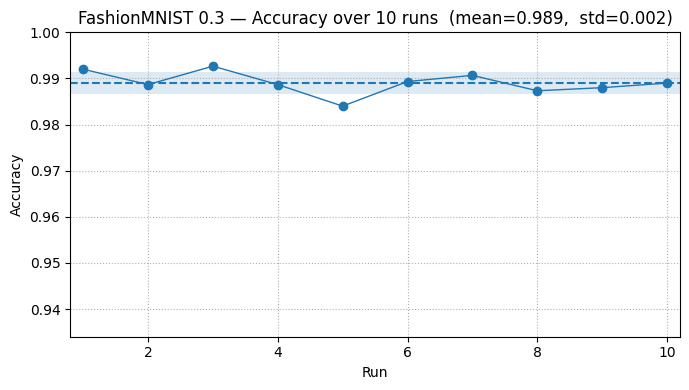

In [93]:
csv_path = Path('results/FashionMNIST0.3.withT_forward_runs.csv')

acc = []
with open(csv_path, newline='') as f:
    rows = list(csv.reader(f))
    for r in rows[1:11]:
        try:
            acc.append(float(r[1]))
        except:
            break


acc = np.array(acc)
runs = np.arange(1, len(acc)+1)
m, s = acc.mean(), acc.std()


plt.figure(figsize=(7,4))
plt.plot(runs, acc, marker='o', linewidth=1)
plt.hlines(m, runs.min()-0.2, runs.max()+0.2, linestyles='dashed', linewidth=1.5)
plt.fill_between([runs.min()-0.2, runs.max()+0.2], m-s, m+s, alpha=0.15)

plt.title(f'FashionMNIST 0.3 — Accuracy over 10 runs  (mean={m:.3f},  std={s:.3f})')
plt.xlabel('Run'); plt.ylabel('Accuracy')
plt.xlim(runs.min()-0.2, runs.max()+0.2)
ymin = max(0.0, acc.min()-0.05); ymax = min(1.0, acc.max()+0.05)
plt.ylim(ymin, ymax)
plt.grid(True, linestyle=':', linewidth=0.8)


plt.tight_layout()
plt.show()


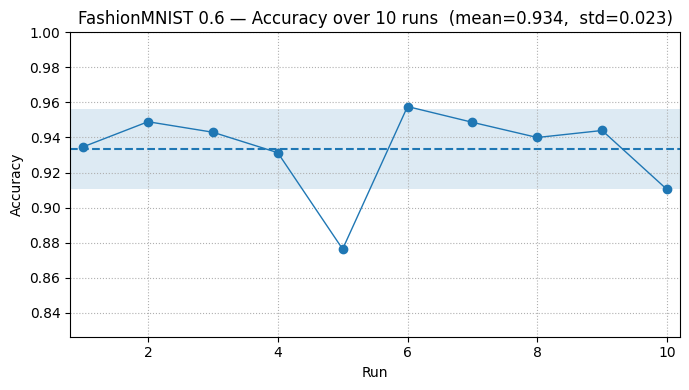

In [94]:
csv_path = Path('results/FashionMNIST0.6.withT_forward_runs.csv')
acc = []
with open(csv_path, newline='') as f:
    rows = list(csv.reader(f))
    for r in rows[1:11]:
        try:
            acc.append(float(r[1]))
        except:
            break


acc = np.array(acc)
runs = np.arange(1, len(acc)+1)
m, s = acc.mean(), acc.std()


plt.figure(figsize=(7,4))
plt.plot(runs, acc, marker='o', linewidth=1)
plt.hlines(m, runs.min()-0.2, runs.max()+0.2, linestyles='dashed', linewidth=1.5)
plt.fill_between([runs.min()-0.2, runs.max()+0.2], m-s, m+s, alpha=0.15)

plt.title(f'FashionMNIST 0.6 — Accuracy over 10 runs  (mean={m:.3f},  std={s:.3f})')
plt.xlabel('Run'); plt.ylabel('Accuracy')
plt.xlim(runs.min()-0.2, runs.max()+0.2)
ymin = max(0.0, acc.min()-0.05); ymax = min(1.0, acc.max()+0.05)
plt.ylim(ymin, ymax)
plt.grid(True, linestyle=':', linewidth=0.8)

plt.tight_layout()
plt.show()


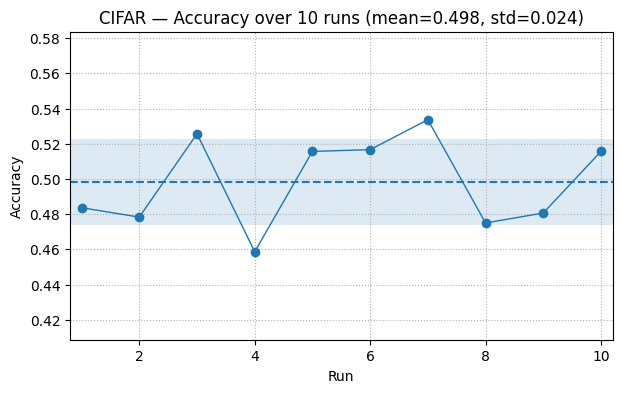

In [95]:
csv_path = Path('results/CIFAR_forward_runs.csv')

acc = []
with open(csv_path, newline='') as f:
    rows = list(csv.reader(f))
    for r in rows[1:11]:
        try:
            acc.append(float(r[1]))
        except:
            break
acc = np.array(acc)
runs = np.arange(1, len(acc)+1)

m, s = acc.mean(), acc.std()

# plot
plt.figure(figsize=(7,4))
plt.plot(runs, acc, marker='o', linewidth=1)
plt.hlines(m, runs.min()-0.2, runs.max()+0.2, linestyles='dashed', linewidth=1.5)
plt.fill_between([runs.min()-0.2, runs.max()+0.2], m-s, m+s, alpha=0.15)

plt.title(f'CIFAR — Accuracy over 10 runs (mean={m:.3f}, std={s:.3f})')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.xlim(runs.min()-0.2, runs.max()+0.2)
ymin = max(0.0, acc.min()-0.05); ymax = min(1.0, acc.max()+0.05)
plt.ylim(ymin, ymax)
plt.grid(True, linestyle=':', linewidth=0.8)

plt.show()
